### This notebook contains the codes to extract and process the necessary simulation data for constructing the machine learning model. The contents must be incorporated to the resilience_metrics.py once finalized.

In [1]:
%load_ext autoreload
%autoreload 2
import warnings
warnings.filterwarnings('ignore')
import os
from IPython.display import clear_output

import os
import pandas as pd
from pathlib import Path
from sklearn import metrics
import statistics
import copy

import infrarisk.src.network_sim_models.interdependencies as interdependencies
from infrarisk.src.network_sim_models.integrated_network import *

In [2]:

network_dir = Path('../../data/networks/micropolis')
power_folder = network_dir/'power/low'
water_folder = network_dir/'water/high'

micropolis_network = IntegratedNetwork(name = 'Micropolis', 
                                       water_folder= water_folder,
                                       power_folder = power_folder,
                                       water_sim_type = 'PDA',
                                       power_sim_type='1ph')

Water network successfully loaded from ..\..\data\networks\micropolis\water\high/water.inp. The analysis type is set to PDA.
initial simulation duration: 60s; hydraulic time step: 60s; pattern time step: 3600s

Power system successfully loaded from ..\..\data\networks\micropolis\power\low\power.json. Single phase power flow simulation will be used.



In [3]:
# Set scenarios folder
folder = Path('../../data/networks/micropolis/scenarios')
scenarios = [f for f in sorted(os.listdir(folder))]
#scenarios = ['beatrice_sim']


In [4]:
#list of recovery strategies to be considered
strategies = ['capacity', 'centrality', 'zone']
#strategies = ['capacity']

#create the empty dataframe for ML dataset
ml_df = pd.DataFrame(columns =["scenario",
         "strategy",
         "meshedness",
         "water_crew",
         "power_crew",
         "transpo_crew",
         'water_perf_ecs',
         'water_perf_pcs',
         'power_perf_ecs',
         'power_perf_pcs',
         'water_mains',
         "power_lines", 
         "transpo_links",
         "all_compons"])

abnormal_results = []
abnormal_results_index =[]

junc_list = micropolis_network.wn.junction_name_list
base_water_demands = micropolis_network.base_water_node_supply
base_power_demands = micropolis_network.base_power_supply


In [5]:
for index, scenario in enumerate(scenarios):
    
    n_PL=0
    n_WPMA=0
    n_TL=0
    power_sum_bet_cent=0
    water_sum_bet_cent=0
    transport_sum_bet_cent=0
    power_sum_deg_cent=0
    water_sum_deg_cent=0
    transport_sum_deg_cent=0
    
    
    print(index, ". ", scenario)
    meshed_levels = os.listdir(f"{folder}/{scenario}")
    for mesh_level in meshed_levels:
        print(mesh_level)
        ml_df_new = {"scenario": scenario,
             "strategy": None,
             "meshedness" : mesh_level,
             "water_crew": 0,
             "power_crew": 0,
             "transpo_crew": 0,
             'water_perf_ecs': None,
             'water_perf_pcs': None,
             'power_perf_ecs': None ,
             'power_perf_pcs': None,
             "water_mains": 0,
             "power_lines": 0, "transpo_links": 0, "all_compons": 0,
             "power_sum_bet_cent":0,"water_sum_bet_cent":0,"transport_sum_bet_cent":0,
             "power_sum_deg_cent":0,"water_sum_deg_cent":0,"transport_sum_deg_cent":0
                    }

        lc_df = pd.read_csv(f"{network_dir}/link_criticality_features_{mesh_level}.csv")
        lc_df.head()
        disruption_file = pd.read_csv(f"{folder}/{scenario}/{mesh_level}/disruption_file.csv")
        ml_df_new["all_compons"] = disruption_file.shape[0]
        for _, row in disruption_file.iterrows():
            if row['components'].startswith('P_L'):
                ml_df_new['power_lines'] += 1
            elif row['components'].startswith('W_PMA'):
                ml_df_new['water_mains'] += 1
            #elif row['components'].startswith('W_T'):
            #    ml_df_new['water_tanks'] += 1
            #elif row['components'].startswith('W_WP'):
            #    ml_df_new['water_pumps'] += 1
            elif row['components'].startswith('T_L'):
                ml_df_new['transpo_links'] += 1
            else:
                print("Component type not detectable.")        


        ml_df_new["all_compons"] = disruption_file.shape[0]


        for _, row in disruption_file.iterrows():

            if ('P_L' in row['components'] or 'W_PMA' in row['components'] or 'T_L' in row['components']):
                lc_df_item = lc_df.loc[(lc_df['id']==row['components'])]
                if lc_df_item.empty:
                    print("%s not found in link criticality" % (row['components']))
                    bet_cent = 0
                    deg_cent = 0
                else:
                    component=lc_df_item['id'].values[0]
                    print(component)
                    bet_cent=lc_df_item['betweenness_centrality'].values[0]
                    deg_cent=lc_df_item['degree_centrality'].values[0]

                    if (component.startswith('P_L')):
                        n_PL=n_PL+1
                        power_sum_bet_cent += bet_cent
                        power_sum_deg_cent += deg_cent

                    elif (component.startswith('W_PMA')):
                        n_WPMA=n_WPMA+1
                        water_sum_bet_cent += bet_cent
                        water_sum_deg_cent += deg_cent

                    elif (component.startswith('T_L')):
                        n_TL=n_TL+1
                        transport_sum_bet_cent += bet_cent
                        transport_sum_deg_cent += deg_cent
            else:
                print("Unknown component %s" % (row['components']))
            ml_df_new['power_sum_bet_cent']=0
            ml_df_new['water_sum_deg_cent']=0
            ml_df_new['water_sum_bet_cent']=0
            ml_df_new['water_sum_deg_cent']=0
            ml_df_new['transport_sum_bet_cent']=0
            ml_df_new['transport_sum_deg_cent']=0

            if (n_PL!=0):
                ml_df_new['power_sum_bet_cent']=power_sum_bet_cent/n_PL
                ml_df_new['power_sum_deg_cent']=power_sum_deg_cent/n_PL
            elif (n_WPMA!=0):
                ml_df_new['water_sum_bet_cent']=water_sum_bet_cent/n_WPMA
                ml_df_new['water_sum_deg_cent']=water_sum_deg_cent/n_WPMA
            elif (n_TL!=0):
                ml_df_new['transport_sum_bet_cent']=transport_sum_bet_cent/n_TL
                ml_df_new['transport_sum_deg_cent']=transport_sum_deg_cent/n_TL


        for strategy in strategies:
            try:
                ml_df_new['strategy'] = strategy
                water_demands_file = f"{folder}/{scenario}/{mesh_level}/{strategy}/water_junc_demand.csv"
                power_demands_file = f"{folder}/{scenario}/{mesh_level}/{strategy}/power_load_demand.csv"
                water_pressure_file = f"{folder}/{scenario}/{mesh_level}/{strategy}/water_node_pressure.csv"
                crew_size_file = f"{folder}/{scenario}/{mesh_level}/{strategy}/crew_size.csv"

                if os.path.isfile(water_demands_file):
                    water_demands = pd.read_csv(water_demands_file, sep = "\t")
                    water_time_list = water_demands.time/60
                    water_time_list = water_time_list.tolist()
                    rel_time_list = water_demands['time'] % (24*3600)
                    #index_list = [int(x/60) for x in rel_time_list]
                    index_list = [int(x/60) for x in rel_time_list if np.isnan(x) == False]
                    water_demands = water_demands[junc_list]

                    #water_pressures = pd.read_csv(water_pressure_file, sep = "\t")
                    #water_pressures = water_pressures[junc_list]
                    #water_press_corrections = copy.deepcopy(water_pressures)

                    # if micropolis_network.water_sim_type == "DDA":
                    #     for index, column in enumerate(water_pressures.columns):
                    #         water_press_corrections[column] = water_pressures[column].apply(lambda x: 0 if x <= 0 
                    #                 else ((x/wn.options.hydraulic.threshold_pressure)**0.5 if x <= wn.options.hydraulic.threshold_pressure else x))
                    #     water_demands = water_demands * water_press_corrections

                    power_demands = pd.read_csv(power_demands_file, sep = "\t")
                    power_time_list = power_demands.time/60
                    power_time_list= power_time_list.tolist()

                    base_water_demands_new = base_water_demands.iloc[index_list].reset_index(drop=True)
                    base_water_demands_new = base_water_demands_new[junc_list]

                    water_demands_ratio = water_demands/ base_water_demands_new
                    #water_demands_ratio = water_demands_ratio.clip(upper=1)
                    water_demands_ratio = water_demands_ratio.clip(upper=1, lower=0)

                    water_ecs_list = water_demands_ratio.mean(axis = 1, skipna = True).tolist()

                    if water_ecs_list[-1] < 0.9:
                        abnormal_results.append(scenario)

                    water_pcs_list = pd.concat([water_demands, base_water_demands_new]).min(level=0).sum(axis=1, skipna = True)/base_water_demands_new.sum(axis=1, skipna = True)
                    water_pcs_list = water_pcs_list.tolist()

                    base_load_demands = pd.DataFrame(base_power_demands.load.p_mw.tolist() + base_power_demands.motor.pn_mech_mw.tolist()).transpose()
                    base_load_demands.columns = base_power_demands.load.name.tolist() + base_power_demands.motor.name.tolist()
                    base_load_demands = pd.concat([base_load_demands]*(power_demands.shape[0])).reset_index(drop=True)

                    power_demand_ratio = power_demands.iloc[:,1:] / base_load_demands
                    power_demand_ratio = power_demand_ratio.clip(upper=1)

                    power_ecs_list = power_demand_ratio.mean(axis = 1, skipna = True).tolist()
                    power_pcs_list = pd.concat([power_demands.iloc[:,1:], base_load_demands]).min(level=0).sum(axis=1, skipna = True)/base_load_demands.sum(axis=1, skipna = True)
                    power_pcs_list = power_pcs_list.tolist()

                    crew_size = pd.read_csv(crew_size_file, sep = ",")
                    ml_df_new['power_crew'] = crew_size.iloc[0, 1]
                    ml_df_new['water_crew'] = crew_size.iloc[1, 1]
                    ml_df_new['transpo_crew'] = crew_size.iloc[2, 1]

                    ml_df_new['water_perf_ecs'] = round(metrics.auc(water_time_list, [1 - x for x in water_ecs_list]), 3)
                    ml_df_new['water_perf_pcs'] = round(metrics.auc(water_time_list, [1 - x for x in water_pcs_list]), 3)
                    ml_df_new['power_perf_ecs'] = round(metrics.auc(power_time_list, [1 - x for x in power_ecs_list]), 3)
                    ml_df_new['power_perf_pcs'] = round(metrics.auc(power_time_list, [1 - x for x in power_pcs_list]), 3)
                    power_auc_df = pd.DataFrame(data = {'time': power_time_list, 
                                                        'ecs': power_ecs_list, 
                                                        'pcs': power_pcs_list})
                    power_auc_df.to_csv(f"{folder}/{scenario}/{mesh_level}/{strategy}/power_auc.csv", index = False)

                    water_auc_df = pd.DataFrame(data = {'time': water_time_list, 
                                                        'ecs': water_ecs_list, 
                                                        'pcs': water_pcs_list})
                    water_auc_df.to_csv(f"{folder}/{scenario}/{mesh_level}/{strategy}/water_auc.csv", index = False)

                    ml_df = ml_df.append(ml_df_new, ignore_index=True)
                    print(ml_df.iloc[-1,:].tolist())

                else:
                    pass
            except (AttributeError, UnicodeDecodeError):
                pass        
    clear_output(wait=True)
    
abnormal_results = list(set(abnormal_results))

901 .  track99
high
W_PMA785
W_PMA755
W_PMA756
W_PMA733
W_PMA818
P_L316
P_L329
P_L391
T_L50
['track99', 'capacity', 'high', 6, 3, 1, 2.641, 2.135, 0.472, 3.788, 5, 3, 1, 9, 0.0084458118303202, 0.0068082788671023665, 0.0, 0.0, 0.0, 0.0]
['track99', 'centrality', 'high', 6, 3, 1, 2.641, 2.135, 0.472, 3.788, 5, 3, 1, 9, 0.0084458118303202, 0.0068082788671023665, 0.0, 0.0, 0.0, 0.0]
['track99', 'zone', 'high', 6, 3, 1, 2.641, 2.135, 0.472, 3.788, 5, 3, 1, 9, 0.0084458118303202, 0.0068082788671023665, 0.0, 0.0, 0.0, 0.0]
low
W_PMA782
P_L323
T_L33
T_L50
['track99', 'capacity', 'low', 1, 1, 3, 12.372, 40.364, 3.732, 10.791, 1, 1, 2, 4, 0.0085782384784981, 0.007557189542483625, 0.0, 0.0, 0.0, 0.0]
['track99', 'centrality', 'low', 1, 1, 3, 12.372, 40.364, 3.732, 10.791, 1, 1, 2, 4, 0.0085782384784981, 0.007557189542483625, 0.0, 0.0, 0.0, 0.0]
['track99', 'zone', 'low', 1, 1, 3, 12.372, 40.364, 3.732, 10.791, 1, 1, 2, 4, 0.0085782384784981, 0.007557189542483625, 0.0, 0.0, 0.0, 0.0]
med
W_PMA782


In [6]:
len(abnormal_results)

259

In [8]:
np.isnan(rel_time_list.to_list()[-1])

False

In [9]:
ml_df.to_csv("auc_df_ecs_with_centrality.csv", index = False)

## Read the csv file for machine learning

In [15]:
ml_df_new = pd.read_csv("auc_df_ecs_with_centrality.csv")
ml_df_new.tail()

,scenario,strategy,meshedness,water_crew,power_crew,transpo_crew,water_perf_ecs,water_perf_pcs,power_perf_ecs,power_perf_pcs,water_mains,power_lines,transpo_links,all_compons,power_sum_bet_cent,power_sum_deg_cent,transport_sum_bet_cent,transport_sum_deg_cent,water_sum_bet_cent,water_sum_deg_cent
7344,track97,centrality,low,3,4,4,1757.074,1801.231,80.943,188.135,14,7,4,25,0.016995,0.0,0.0,0.0,0.0,0.006250
7345,track97,zone,low,3,4,4,1991.506,2031.865,92.690,228.254,14,7,4,25,0.016995,0.0,0.0,0.0,0.0,0.006250
7346,track97,capacity,med,5,4,6,1094.253,1116.084,35.671,35.522,14,11,5,30,0.017019,0.0,0.0,0.0,0.0,0.006246
7347,track97,centrality,med,5,4,6,1466.841,1501.740,33.924,33.480,14,11,5,30,0.017019,0.0,0.0,0.0,0.0,0.006246
7348,track97,zone,med,5,4,6,1533.473,1577.642,35.229,34.492,14,11,5,30,0.017019,0.0,0.0,0.0,0.0,0.006246


In [16]:
ml_df_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7349 entries, 0 to 7348
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   scenario                7349 non-null   object 
 1   strategy                7349 non-null   object 
 2   meshedness              7349 non-null   object 
 3   water_crew              7349 non-null   int64  
 4   power_crew              7349 non-null   int64  
 5   transpo_crew            7349 non-null   int64  
 6   water_perf_ecs          7349 non-null   float64
 7   water_perf_pcs          7349 non-null   float64
 8   power_perf_ecs          7349 non-null   float64
 9   power_perf_pcs          7349 non-null   float64
 10  water_mains             7349 non-null   int64  
 11  power_lines             7349 non-null   int64  
 12  transpo_links           7349 non-null   int64  
 13  all_compons             7349 non-null   int64  
 14  power_sum_bet_cent      7349 non-null   

In [17]:
ml_df_new['ecs_auc'] = ml_df_new['water_perf_ecs']*0.5 + ml_df_new['power_perf_ecs']*0.5
ml_df_new['pcs_auc'] = ml_df_new['water_perf_pcs']*0.5 + ml_df_new['power_perf_pcs']*0.5
ml_df_new.head()

,scenario,strategy,meshedness,water_crew,power_crew,transpo_crew,water_perf_ecs,water_perf_pcs,power_perf_ecs,power_perf_pcs,...,transpo_links,all_compons,power_sum_bet_cent,power_sum_deg_cent,transport_sum_bet_cent,transport_sum_deg_cent,water_sum_bet_cent,water_sum_deg_cent,ecs_auc,pcs_auc
0,point134,capacity,high,1,1,1,0.0,0.0,0.0,0.0,...,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,point134,centrality,high,1,1,1,0.0,0.0,0.0,0.0,...,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,point134,zone,high,1,1,1,0.0,0.0,0.0,0.0,...,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,point153,capacity,high,1,1,2,0.0,0.0,0.0,0.0,...,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,point153,centrality,high,1,1,2,0.0,0.0,0.0,0.0,...,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [18]:
ml_df_new.columns

Index(['scenario', 'strategy', 'meshedness', 'water_crew', 'power_crew',
       'transpo_crew', 'water_perf_ecs', 'water_perf_pcs', 'power_perf_ecs',
       'power_perf_pcs', 'water_mains', 'power_lines', 'transpo_links',
       'all_compons', 'power_sum_bet_cent', 'power_sum_deg_cent',
       'transport_sum_bet_cent', 'transport_sum_deg_cent',
       'water_sum_bet_cent', 'water_sum_deg_cent', 'ecs_auc', 'pcs_auc'],
      dtype='object')

## Importing the libraries for machine learning

In [36]:
import numpy as np
# importing libraries
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import  RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt

## Data Cleaning

In [21]:
#removing null, infinite values
ml_df_new=ml_df_new[~ml_df_new.isin([np.nan, np.inf, -np.inf]).any(1)]
ml_df_new=ml_df_new.dropna()

print(max(ml_df_new.ecs_auc))
print(min(ml_df_new.ecs_auc))

#removing outliers from the data
ml_df_new = ml_df_new.drop(ml_df_new[ml_df_new.ecs_auc > 3000].index)
ml_df_new.info()

3492.3975
0.0
<class 'pandas.core.frame.DataFrame'>
Int64Index: 7337 entries, 0 to 7348
Data columns (total 22 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   scenario                7337 non-null   object 
 1   strategy                7337 non-null   object 
 2   meshedness              7337 non-null   object 
 3   water_crew              7337 non-null   int64  
 4   power_crew              7337 non-null   int64  
 5   transpo_crew            7337 non-null   int64  
 6   water_perf_ecs          7337 non-null   float64
 7   water_perf_pcs          7337 non-null   float64
 8   power_perf_ecs          7337 non-null   float64
 9   power_perf_pcs          7337 non-null   float64
 10  water_mains             7337 non-null   int64  
 11  power_lines             7337 non-null   int64  
 12  transpo_links           7337 non-null   int64  
 13  all_compons             7337 non-null   int64  
 14  power_sum_bet_cent      73

In [22]:
# separate the independent and target variable 
ml_df_new = ml_df_new.drop(columns=['water_perf_pcs','power_perf_pcs',
                              'water_perf_ecs','power_perf_ecs',
                              'all_compons','scenario','pcs_auc'])

In [23]:
print(ml_df_new.columns)
ml_df_new.shape
ml_df_new.info()

Index(['strategy', 'meshedness', 'water_crew', 'power_crew', 'transpo_crew',
       'water_mains', 'power_lines', 'transpo_links', 'power_sum_bet_cent',
       'power_sum_deg_cent', 'transport_sum_bet_cent',
       'transport_sum_deg_cent', 'water_sum_bet_cent', 'water_sum_deg_cent',
       'ecs_auc'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
Int64Index: 7337 entries, 0 to 7348
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   strategy                7337 non-null   object 
 1   meshedness              7337 non-null   object 
 2   water_crew              7337 non-null   int64  
 3   power_crew              7337 non-null   int64  
 4   transpo_crew            7337 non-null   int64  
 5   water_mains             7337 non-null   int64  
 6   power_lines             7337 non-null   int64  
 7   transpo_links           7337 non-null   int64  
 8   power_sum_bet_cent      7337 non

In [24]:
ml_df_new = pd.get_dummies(ml_df_new)


In [25]:
ml_df_new.head()


,water_crew,power_crew,transpo_crew,water_mains,power_lines,transpo_links,power_sum_bet_cent,power_sum_deg_cent,transport_sum_bet_cent,transport_sum_deg_cent,water_sum_bet_cent,water_sum_deg_cent,ecs_auc,strategy_capacity,strategy_centrality,strategy_zone,meshedness_high,meshedness_low,meshedness_med
0,1,1,1,0,0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,1,0,0
1,1,1,1,0,0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0,1,0,0
2,1,1,1,0,0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,1,1,0,0
3,1,1,2,0,0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,1,0,0
4,1,1,2,0,0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0,1,0,0


In [26]:
ml_df_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7337 entries, 0 to 7348
Data columns (total 19 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   water_crew              7337 non-null   int64  
 1   power_crew              7337 non-null   int64  
 2   transpo_crew            7337 non-null   int64  
 3   water_mains             7337 non-null   int64  
 4   power_lines             7337 non-null   int64  
 5   transpo_links           7337 non-null   int64  
 6   power_sum_bet_cent      7337 non-null   float64
 7   power_sum_deg_cent      7337 non-null   float64
 8   transport_sum_bet_cent  7337 non-null   float64
 9   transport_sum_deg_cent  7337 non-null   float64
 10  water_sum_bet_cent      7337 non-null   float64
 11  water_sum_deg_cent      7337 non-null   float64
 12  ecs_auc                 7337 non-null   float64
 13  strategy_capacity       7337 non-null   uint8  
 14  strategy_centrality     7337 non-null   

In [27]:
train_X = ml_df_new.drop(columns=['ecs_auc'])
train_Y = ml_df_new['ecs_auc']

In [28]:
max(ml_df_new['ecs_auc'])

2943.9695

In [29]:
#data=pd.concat([train_X, train_Y], axis=1, ignore_index=False)

In [30]:
#data

In [31]:
"""
from numpy import asarray
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaled = scaler.fit_transform(data)
print(scaled)
"""

'\nfrom numpy import asarray\nfrom sklearn.preprocessing import MinMaxScaler\nscaler = MinMaxScaler()\nscaled = scaler.fit_transform(data)\nprint(scaled)\n'

## Preparing data for training
### Normalise data

In [32]:
# separate into input and output columns
#X, y = scaled[:, 0:15], scaled[:, 15]
# ensure inputs are floats and outpu

In [33]:
#train_Y = ml_df['label_new']   #for normalise data
#print(train_Y)
# randomly split the data
train_x, test_x, train_y, test_y = train_test_split(train_X, train_Y,test_size=0.25,random_state=0)

# shape of train and test splits
train_x.shape, test_x.shape, train_y.shape, test_y.shape

((5502, 18), (1835, 18), (5502,), (1835,))

## Random Forest Regressor

In [37]:
# create an object of the RandomForestRegressor
model_RFR = RandomForestRegressor(max_depth=3)

# fit the model with the training data
model_RFR.fit(train_x, train_y)

# predict the target on train and test data
predict_train = model_RFR.predict(train_x)
predict_test = model_RFR.predict(test_x)

# Root Mean Squared Error on train and test data
print('Original RMSE on train data: ', mean_squared_error(train_y, predict_train)**(0.5))
print('Original RMSE on test data: ',  mean_squared_error(test_y, predict_test)**(0.5))

# Mean Squared Error on train and test data
print('MSE on train data: ', mean_squared_error(train_y, predict_train))
print('MSE on test data: ',  mean_squared_error(test_y, predict_test))

# Root Mean Squared Error on train and test data
print('RMSE on train data: ', mean_squared_error(train_y, predict_train, squared=False))
print('RMSE on test data: ',  mean_squared_error(test_y, predict_test, squared=False))

# Mean Absolute Error on train and test data
print('MAE on train data: ', mean_absolute_error(train_y, predict_train))
print('MAE on test data: ',  mean_absolute_error(test_y, predict_test))

# Mean Absolute Percentage Error on train and test data
print('MAPE on train data: ', mean_absolute_percentage_error(train_y, predict_train))
print('MAPE on test data: ',  mean_absolute_percentage_error(test_y, predict_test))

r2_score = model_RFR.score(test_x,test_y)
print(r2_score*100,'%')


Original RMSE on train data:  217.4774306832974
Original RMSE on test data:  219.9317527111754
MSE on train data:  47296.43285660843
MSE on test data:  48369.975850609604
RMSE on train data:  217.4774306832974
RMSE on test data:  219.9317527111754
MAE on train data:  137.49039615715395
MAE on test data:  138.11760565410148
MAPE on train data:  2979844966763546.0
MAPE on test data:  2362795501377956.0
65.75195542230257 %


## Feature importance

Index(['water_crew', 'power_crew', 'transpo_crew', 'water_mains',
       'power_lines', 'transpo_links', 'power_sum_bet_cent',
       'power_sum_deg_cent', 'transport_sum_bet_cent',
       'transport_sum_deg_cent', 'water_sum_bet_cent', 'water_sum_deg_cent',
       'strategy_capacity', 'strategy_centrality', 'strategy_zone',
       'meshedness_high', 'meshedness_low', 'meshedness_med'],
      dtype='object')
[0.387 0.    0.    0.611 0.    0.    0.002 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.   ]


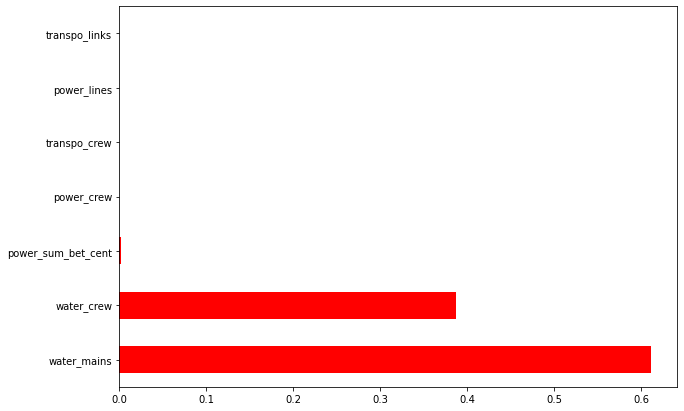

In [38]:
# plot the 7 most important features 
plt.figure(figsize=(10,7))
feat_importances = pd.Series(model_RFR.feature_importances_, index = train_X.columns)
feat_importances.nlargest(7).plot(kind='barh',color='red');

print(train_X.columns)
print(model_RFR.feature_importances_)

## Linear regression

In [39]:
# create an object of the LinearRegression Model
model_LR = LinearRegression()

# fit the model with the training data
model_LR.fit(train_x, train_y)

# predict the target on train and test data 
predict_train = model_LR.predict(train_x)
predict_test  = model_LR.predict(test_x)


print('Coefficients: \n', model_LR.coef_)

# Root Mean Squared Error on train and test date
print('RMSE on train data: ', mean_squared_error(train_y, predict_train)**(0.5))
print('RMSE on test data: ',  mean_squared_error(test_y, predict_test)**(0.5))

r2_score = model_LR.score(test_x,test_y)
print(r2_score*100,'%')

Coefficients: 
 [-8.668e+01 -1.008e+01 -3.591e+01  4.882e+01  1.114e+01  5.840e+01  2.948e+03  1.046e-11  2.899e-12 -8.868e-12  2.602e+02 -9.275e+03 -1.539e+01 -7.813e+00  2.320e+01 -3.078e+01  5.086e+01 -2.008e+01]
RMSE on train data:  241.68630497057828
RMSE on test data:  233.6697021389031
61.339744537557515 %


In [40]:
df = pd.DataFrame(test_y)
df['predict_linear_reg']=predict_test
df

,ecs_auc,predict_linear_reg
4763,356.5180,221.631031
3322,0.5570,-70.901093
7127,1052.3705,902.371567
5016,0.9790,89.858427
311,425.5900,411.691164
...,...,...
5344,304.7440,512.847334
3584,29.2490,28.197437
1464,347.6095,390.490842
84,0.0000,-114.766880


(5502, 18)
(5502,)


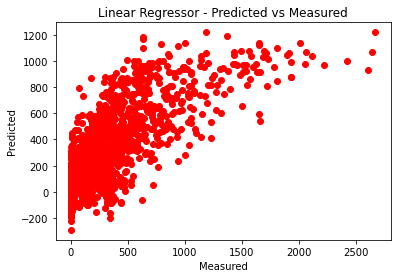

In [41]:
print(train_x.shape)
print(train_y.shape)
import matplotlib.pyplot as plt
plt.scatter(test_y,predict_test,color='red')

plt.title("Linear Regressor - Predicted vs Measured")
plt.xlabel("Measured")
plt.ylabel("Predicted")
plt.show()

In [42]:
#train_Y = ml_df['label_new']   #for normalise data
#print(train_Y)
# randomly split the data
train_x, test_x, train_y, test_y = train_test_split(train_X, train_Y,test_size=0.25,random_state=0)

# shape of train and test splits
train_x.shape, test_x.shape, train_y.shape, test_y.shape

((5502, 18), (1835, 18), (5502,), (1835,))

## Random Forest with feature selection

In [26]:
# training data with 7 most important features
train_x_if = train_x[['water_mains',  'power_lines',
       'transpo_links', 'water_sum_deg_cent', 'water_pumps',
       'power_sum_bet_cent', 'water_tanks']]
# test data with 7 most important features
test_x_if = test_x[['water_mains',  'power_lines',
       'transpo_links', 'water_sum_deg_cent', 'water_pumps',
       'water_sum_bet_cent', 'water_tanks']]

# create an object of the RandfomForestRegressor Model
model_RFR_with_if = RandomForestRegressor(max_depth=10,random_state=2)

# fit the model with the training data
model_RFR_with_if.fit(train_x_if, train_y)

# predict the target on the training and test data
predict_train_with_if = model_RFR_with_if.predict(train_x_if)
predict_test_with_if = model_RFR_with_if.predict(test_x_if)
# Root Mean Squared Error on the train and test data
print('RMSE on train data: ', mean_squared_error(train_y, predict_train_with_if)**(0.5))
print('RMSE on test data: ',  mean_squared_error(test_y, predict_test_with_if)**(0.5))

r2_score = model_RFR_with_if.score(test_x_if,test_y)
print(r2_score*100,'%')


RMSE on train data:  241.01483686926733
RMSE on test data:  356.46027840149134
73.46214564402342 %


In [27]:
from sklearn.ensemble import RandomForestRegressor
from sklearn import model_selection
rf_estimator = RandomForestRegressor(random_state=2017)
#n_estimators: no.of trees to be built
#max_features: Maximum no. of features to try with
rf_grid = {'bootstrap': [True, False],
 'max_depth': [10, 20, 30, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [50, 100, 200, 300]}
rf_grid_estimator = model_selection.GridSearchCV(rf_estimator,rf_grid, cv=10, n_jobs=10)
rf_grid_estimator.fit(train_x_if, train_y)
print(rf_grid_estimator.best_estimator_)
rf_grid_estimator.best_score_
rf_grid_estimator.score(test_x_if, test_y)

RandomForestRegressor(max_depth=20, min_samples_leaf=2, min_samples_split=5,
                      n_estimators=300, random_state=2017)


0.7287974812814635

### Evaluate 

In [28]:
# predict the target on the training and test data
predict_train_with_if = rf_grid_estimator.predict(train_x_if)
predict_test_with_if = rf_grid_estimator.predict(test_x_if)
# Root Mean Squared Error on the train and test data

print('RMSE on train data: ', mean_squared_error(train_y, predict_train_with_if)**(0.5))
print('RMSE on test data: ',  mean_squared_error(test_y, predict_test_with_if)**(0.5))



r2_score = rf_grid_estimator.score(test_x_if,test_y)
print(r2_score*100,'%')



RMSE on train data:  234.24368029900793
RMSE on test data:  360.35047437515914
72.87974812814635 %


In [29]:
df['predict_random_forest']=predict_test_with_if
df

,ecs_auc,predict_linear_reg,predict_random_forest
540,0.0000,-124.431870,0.000000
3983,834.6335,321.809090,111.533525
592,34.3790,42.688630,139.233092
2538,0.0000,-129.674740,0.000000
4640,0.0000,-124.431870,0.000000
...,...,...,...
4148,337.0915,283.529029,98.177114
2869,1425.9845,1453.297935,1392.082370
998,1911.4950,1603.491047,1474.231643
2662,227.3995,171.224687,181.815819


(3492, 15)
(3492,)


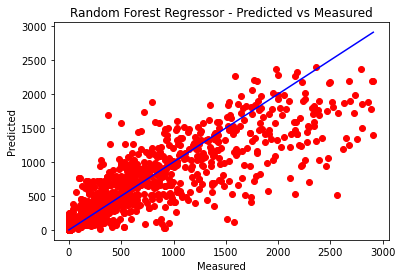

In [31]:
print(train_x.shape)
print(train_y.shape)
import matplotlib.pyplot as plt
plt.scatter(test_y,predict_test_with_if,color='red')
p1 = max(max(predict_test_with_if), max(test_y))
p2 = min(min(predict_test_with_if), min(test_y))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.title("Random Forest Regressor - Predicted vs Measured")
plt.xlabel("Measured")
plt.ylabel("Predicted")
plt.show()

## Gradient boosting regressor

In [32]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn import ensemble
params={'n_estimators':100,'max_depth': 3, 'learning_rate': 1, 'criterion': 'mse'}
gradient_boosting_regressor_model = ensemble.GradientBoostingRegressor(**params)
gradient_boosting_regressor_model.fit(train_x,train_y)
y_pred = gradient_boosting_regressor_model.predict(test_x)   


Index(['water_mains', 'water_pumps', 'water_tanks', 'power_lines',
       'transpo_links', 'power_sum_bet_cent', 'power_sum_deg_cent',
       'transport_sum_bet_cent', 'transport_sum_deg_cent',
       'water_sum_bet_cent', 'water_sum_deg_cent', 'strategy_capacity',
       'strategy_centrality', 'strategy_crewdist', 'strategy_zone'],
      dtype='object')
[0.723 0.    0.    0.025 0.112 0.067 0.    0.    0.    0.005 0.045 0.009 0.002 0.009 0.003]


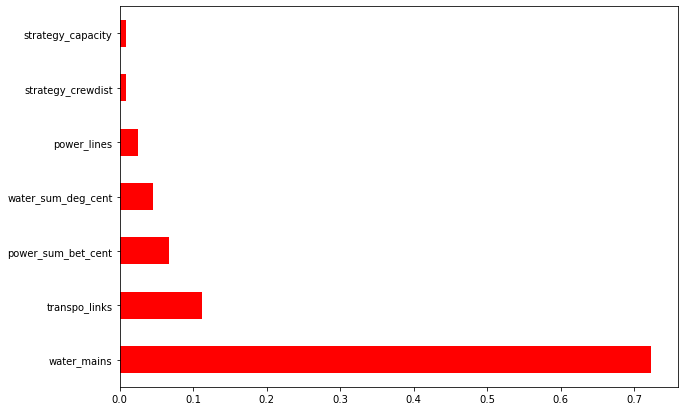

In [33]:
# plot the 7 most important features 
plt.figure(figsize=(10,7))
feat_importances = pd.Series(gradient_boosting_regressor_model.feature_importances_, index = train_X.columns)
feat_importances.nlargest(7).plot(kind='barh',color='red');

print(train_X.columns)
print(gradient_boosting_regressor_model.feature_importances_)

### Evaluate 

In [34]:
gradient_boosting_regressor_model.score(test_x, test_y, sample_weight=None)
r2_score = gradient_boosting_regressor_model.score(test_x,test_y)
print(r2_score*100,'%')
# Root Mean Squared Error on the train and test data
print('RMSE on test data: ',  mean_squared_error(test_y, y_pred)**(0.5))


72.39938451566015 %
RMSE on test data:  363.52779498911866


## Gradient boosting regressor hyper parameter tuning

In [35]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn import model_selection
gbr_estimator = ensemble.GradientBoostingRegressor(random_state=2017)
#n_estimators: no.of trees to be built
#max_features: Maximum no. of features to try with
gbr_grid = {'n_estimators':[10,50,100,150,200],'max_depth': [2,4,6,8,10], 'learning_rate': [0.1,0.01,1],
            'min_samples_split':[2,5,10]}
grb_grid_estimator = model_selection.GridSearchCV(gbr_estimator,gbr_grid, cv=10, n_jobs=10)
grb_grid_estimator.fit(train_x, train_y)
print(grb_grid_estimator.best_estimator_)
grb_grid_estimator.best_score_
grb_grid_estimator.score(test_x, test_y)

GradientBoostingRegressor(max_depth=4, min_samples_split=5, n_estimators=200,
                          random_state=2017)


0.7668592595537529

In [36]:
y_pred = grb_grid_estimator.predict(test_x)   

In [37]:
grb_grid_estimator.score(test_x, test_y)
r2_score = grb_grid_estimator.score(test_x,test_y)
print(r2_score*100,'%')
# Root Mean Squared Error on the train and test data
print('RMSE on test data: ',  mean_squared_error(test_y, y_pred)**(0.5))

76.6859259553753 %
RMSE on test data:  334.1083460888672


## Gradient boosting regressor feature importance hyper parameter tuning

In [38]:
# training data with 7 most important features
train_x_if = train_x[['water_mains',  'power_lines',
       'transpo_links','strategy_capacity', 'water_sum_deg_cent','strategy_crewdist','power_sum_bet_cent']]
# test data with 7 most important features
test_x_if = test_x[['water_mains',  'power_lines',
       'transpo_links','strategy_capacity', 'water_sum_deg_cent','strategy_crewdist','power_sum_bet_cent']]

# create an object of the RandfomForestRegressor Model

model_gbr_if_estimator = ensemble.GradientBoostingRegressor(random_state=2017)
#n_estimators: no.of trees to be built
#max_features: Maximum no. of features to try with
gbr_grid = {'n_estimators':[10,50,100,150,200],'max_depth': [2,4,6,8,10], 'learning_rate': [0.1,0.01,1],
            'min_samples_split':[2,5,10]}
grb_grid_estimator = model_selection.GridSearchCV(model_gbr_if_estimator,gbr_grid, cv=10, n_jobs=10)
grb_grid_estimator.fit(train_x_if, train_y)
print(grb_grid_estimator.best_estimator_)


GradientBoostingRegressor(max_depth=4, min_samples_split=5, n_estimators=200,
                          random_state=2017)


In [39]:
grb_grid_estimator.best_score_
grb_grid_estimator.score(test_x_if, test_y)

# predict the target on the training and test data
predict_train_with_if = grb_grid_estimator.predict(train_x_if)
predict_test_with_if = grb_grid_estimator.predict(test_x_if)

# Root Mean Squared Error on the train and test data
print('RMSE on train data: ', mean_squared_error(train_y, predict_train_with_if)**(0.5))
print('RMSE on test data: ',  mean_squared_error(test_y, predict_test_with_if)**(0.5))

r2_score = grb_grid_estimator.score(test_x_if,test_y)
print(r2_score*100,'%')

RMSE on train data:  252.5273139903792
RMSE on test data:  331.2443323552028
77.08391445986817 %


In [40]:
df['predict_gradient_boosting']=predict_test_with_if
df

,ecs_auc,predict_linear_reg,predict_random_forest,predict_gradient_boosting
540,0.0000,-124.431870,0.000000,-14.105263
3983,834.6335,321.809090,111.533525,128.043367
592,34.3790,42.688630,139.233092,32.002733
2538,0.0000,-129.674740,0.000000,-14.105263
4640,0.0000,-124.431870,0.000000,-14.105263
...,...,...,...,...
4148,337.0915,283.529029,98.177114,229.395612
2869,1425.9845,1453.297935,1392.082370,1506.007264
998,1911.4950,1603.491047,1474.231643,1463.441030
2662,227.3995,171.224687,181.815819,204.704402


(3492, 15)
(3492,)


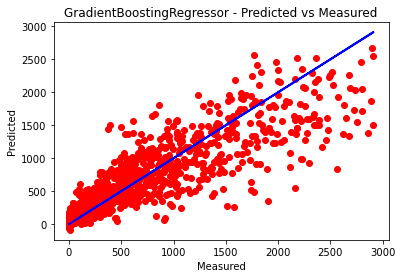

In [78]:
print(train_x.shape)
print(train_y.shape)
import matplotlib.pyplot as plt
plt.scatter(test_y,predict_test_with_if,color='red')
#p1 = max(max(predict_test_with_if), max(test_y))
#p2 = min(min(predict_test_with_if), min(test_y))
#plt.plot([p1, p2], [p1, p2], 'b-')

plt.plot(df['ecs_auc'], test_y, 'b', linewidth=2)
#x_range = np.linspace(test_y.min(), test_y.max(), 100)
#y_range = grb_grid_estimator.predict(x_range.reshape(-1, 1))

plt.title("GradientBoostingRegressor - Predicted vs Measured")
plt.xlabel("Measured")
plt.ylabel("Predicted")
plt.show()

In [113]:
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from sklearn.preprocessing import PolynomialFeatures

def format_coefs(coefs):
    equation_list = [f"{coef}x^{i}" for i, coef in enumerate(coefs)]
    equation = "$" +  " + ".join(equation_list) + "$"

    replace_map = {"x^0": "", "x^1": "x", '+ -': '- '}
    for old, new in replace_map.items():
        equation = equation.replace(old, new)

    return equation

#df = px.data.tips()
X = df.ecs_auc.values.reshape(-1, 1)
x_range = np.linspace(X.min(), X.max(), 100).reshape(-1, 1)

print(x_range.shape)
fig = px.scatter(df,x='ecs_auc',y='predict_gradient_boosting',opacity=0.65)

for degree in [1,2,3,4]:
    poly = PolynomialFeatures(degree)
    poly.fit(X)
    X_poly = poly.transform(X)
    x_range_poly = poly.transform(x_range)
    

    model = LinearRegression(fit_intercept=False)
    model.fit(X_poly, df.predict_gradient_boosting)
    y_poly = model.predict(x_range_poly)

    equation = format_coefs(model.coef_.round(2))
    fig.add_traces(go.Scatter(x=x_range.squeeze(), y=y_poly, name=equation))

fig.show()

(100, 1)


Support Vector Regressor

In [102]:
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
param_grid = { 'C':[0.1,1,100],'kernel':['linear'],'degree':[1,2,3,4,5,6],'gamma': [1, 0.1, 0.01, 0.001, 0.0001]}
grid = GridSearchCV(SVR(),param_grid)
grid.fit(train_x,train_y)


GridSearchCV(estimator=SVR(),
             param_grid={'C': [0.1, 1, 100], 'degree': [1, 2, 3, 4, 5, 6],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['linear']})

In [103]:
y_pred = grid.predict(test_x)


# Root Mean Squared Error on the train and test data
print('RMSE on test data: ',  mean_squared_error(test_y, y_pred)**(0.5))

r2_score = grid.score(test_x,test_y)
print(r2_score*100,'%')


RMSE on test data:  401.80615006829737
66.28084505574215 %


(3492, 15)
(3492,)


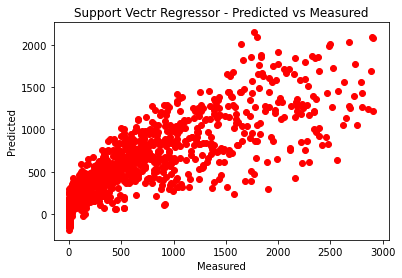

In [104]:
print(train_x.shape)
print(train_y.shape)
import matplotlib.pyplot as plt
plt.scatter(test_y,y_pred,color='red')

plt.title("Support Vectr Regressor - Predicted vs Measured")
plt.xlabel("Measured")
plt.ylabel("Predicted")
plt.show()

In [55]:
df['predict_support_vector']=y_pred
df

,ecs_auc,predict_random_forest,predict_linear_reg,predict_gradient_boosting,predict_support_vector
540,0.0000,0.000000,-124.431870,-14.105263,-72.572674
3983,834.6335,111.533525,321.809090,128.043367,214.533246
592,34.3790,139.233092,42.688630,32.002733,107.662725
2538,0.0000,0.000000,-129.674740,-14.105263,-97.566997
4640,0.0000,0.000000,-124.431870,-14.105263,-72.572674
...,...,...,...,...,...
4148,337.0915,98.177114,283.529029,229.395612,215.485524
2869,1425.9845,1392.082370,1453.297935,1506.007264,1352.064715
998,1911.4950,1474.231643,1603.491047,1463.441030,1445.919473
2662,227.3995,181.815819,171.224687,204.704402,244.953809


In [105]:
df.to_csv('predicted vs actual - with centrality.csv')

In [112]:
df=pd.read_csv('predicted vs actual - with centrality.csv')